In [31]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
#import plotly.express as px
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
# player_data.csv is dervied from player_stats, adding height and weight
player_data = pd.read_csv('./data/player_data.csv')

In [5]:
player_data.head()

,Unnamed: 0,PLAYER_ID,SEASON_ID,TEAM_ID_x,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,WEIGHT,JERSEY,TEAM_ID_y,SEASON_EXP,PTS_y,AST_y,REB_y,draft_flag,year_in_game,player_age
0,0,66,1995-96,1610612750,MIN,26.0,53,0.0,369.0,5.3,...,230.0,33,1610612750,0,2.5,0.2,1.5,False,0,50
1,1,66,1995-96,1610612750,MIN,26.0,53,0.0,369.0,5.3,...,230.0,33,1610612750,0,2.5,0.2,1.5,False,0,50
2,2,74,1994-95,1610612758,SAC,22.0,3,0.0,5.0,0.0,...,181.0,5,1610612758,0,0.0,0.3,0.0,False,0,48
3,3,74,1994-95,1610612758,SAC,22.0,3,0.0,5.0,0.0,...,181.0,5,1610612758,0,0.0,0.3,0.0,False,0,48
4,4,132,1994-95,1610612744,GOS,23.0,41,6.0,395.0,4.6,...,195.0,50,1610612744,0,4.1,0.4,1.4,True,0,49


In [6]:
player_data.shape

(23184, 39)

In [7]:
player_data = player_data.drop(['Unnamed: 0','TEAM_ID_y','player_age','JERSEY','BIRTHDATE','year_in_game'], axis=1)

# player_age is their current age
# PLAYER_AGE is age at time of game

# Height and Weight is averaged among all players, not yet for position


In [8]:
player_data = player_data[player_data['SEASON_ID'] > '2003-04'] 
player_data = player_data[player_data['SEASON_ID'] < '2019-20'] 

In [9]:
player_data.shape

(7118, 33)

In [10]:
player_data.head()

,PLAYER_ID,SEASON_ID,TEAM_ID_x,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,...,TOV,PF,PTS_x,HEIGHT,WEIGHT,SEASON_EXP,PTS_y,AST_y,REB_y,draft_flag
156,2696,2006-07,1610612749,MIL,27.0,41,0.0,432.0,5.1,11.8,...,1.5,2.7,13.9,74.0,175.0,1,4.1,1.3,0.7,False
157,2696,2006-07,1610612749,MIL,27.0,41,0.0,432.0,5.1,11.8,...,1.5,2.7,13.9,74.0,175.0,1,4.1,1.3,0.7,False
160,2763,2004-05,1610612746,LAC,24.0,36,0.0,433.0,3.5,10.4,...,2.0,2.5,9.2,72.0,180.0,1,3.1,1.4,0.9,True
161,2763,2004-05,1610612746,LAC,24.0,36,0.0,433.0,3.5,10.4,...,2.0,2.5,9.2,72.0,180.0,1,3.1,1.4,0.9,True
162,2779,2006-07,1610612745,HOU,24.0,31,0.0,272.0,3.0,9.5,...,3.8,4.4,11.3,76.0,195.0,0,2.7,0.9,0.7,True


In [11]:
player_data.isnull().sum()

PLAYER_ID            0
SEASON_ID            0
TEAM_ID_x            0
TEAM_ABBREVIATION    0
PLAYER_AGE           0
GP                   0
GS                   0
MIN                  0
FGM                  0
FGA                  0
FG_PCT               0
FG3M                 0
FG3A                 0
FG3_PCT              0
FTM                  0
FTA                  0
FT_PCT               0
OREB                 0
DREB                 0
REB_x                0
AST_x                0
STL                  0
BLK                  0
TOV                  0
PF                   0
PTS_x                0
HEIGHT               0
WEIGHT               0
SEASON_EXP           0
PTS_y                0
AST_y                0
REB_y                0
draft_flag           0
dtype: int64

In [12]:
# Looks like TOT rows have averages from point values for the same season
# But it does sum the minutes

# First sort by Team_ID to put 0's at the top per same player and season
# Dedup and keep the TOT row

player_data.sort_values('TEAM_ID_x')

,PLAYER_ID,SEASON_ID,TEAM_ID_x,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,...,TOV,PF,PTS_x,HEIGHT,WEIGHT,SEASON_EXP,PTS_y,AST_y,REB_y,draft_flag
7419,2202,2008-09,0,TOT,28.0,72,71.0,2410.0,6.9,14.5,...,1.4,2.2,18.1,78.0,225.0,13,17.1,2.7,5.0,True
19150,201632,2012-13,0,TOT,28.0,30,0.0,322.0,3.9,9.2,...,3.5,6.7,9.4,86.0,265.0,5,2.2,0.3,2.5,False
19154,201785,2010-11,0,TOT,25.0,17,1.0,322.0,3.5,7.3,...,1.6,3.6,10.4,77.0,210.0,2,3.8,0.6,2.6,False
19157,201785,2013-14,0,TOT,28.0,6,1.0,47.0,2.3,4.6,...,0.8,2.3,6.9,77.0,210.0,2,3.8,0.6,2.6,False
20204,202699,2015-16,0,TOT,23.0,76,74.0,2513.0,6.0,12.7,...,1.5,2.2,16.0,80.0,226.0,9,20.8,3.6,7.7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21250,203798,2015-16,1610612766,CHA,23.0,48,43.0,938.0,3.8,10.6,...,0.9,4.1,11.0,78.0,230.0,2,6.0,0.5,2.4,True
8083,2436,2009-10,1610612766,CHA,30.0,46,1.0,993.0,5.8,14.9,...,2.4,2.8,16.5,75.0,200.0,8,9.9,2.3,2.1,True
8093,2437,2005-06,1610612766,CHA,27.0,18,0.0,119.0,3.6,9.6,...,2.1,2.4,10.8,80.0,260.0,3,3.9,0.2,2.9,True
19499,201974,2011-12,1610612766,CHA,24.0,65,17.0,1443.0,5.3,10.2,...,1.4,2.4,13.1,80.0,233.0,3,5.2,0.7,2.4,True


In [15]:
player_tot = player_data.drop_duplicates(subset = ['PLAYER_ID', 'SEASON_ID'], keep = 'first')

In [16]:
player_tot.shape

(5592, 33)

In [17]:
# Calculate MPG (minutes per game as MIN / GP)
#player_tot['MPG'] = player_tot['MIN'] / player_tot['GP']
player_tot2 = player_tot.loc[:]
player_tot2['MPG'] = round(player_tot['MIN'] / player_tot['GP'], 1)

player_tot = player_tot2
#player_tot['MPG'] = player_tot.apply(lambda row: ((row.MIN) / (row.GP)), axis=1)

In [86]:
player_tot
player_tot.to_csv("./data/kmeans_data.csv")

In [19]:
y=player_tot[['PLAYER_ID', 'SEASON_ID', 'TEAM_ID_x','TEAM_ABBREVIATION']]

In [20]:
# Define features
x= player_tot[['MPG', 'GS', 'FGA', 'FG_PCT', 'FG3A', 'FG3_PCT', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'AST_x', 'STL', 'BLK', 'TOV', 'PF', 'PTS_x']]

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [22]:
X_train

,MPG,GS,FGA,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST_x,STL,BLK,TOV,PF,PTS_x
20919,25.1,52.0,11.8,0.492,4.9,0.382,2.5,0.814,2.3,8.4,2.0,1.5,1.6,1.9,4.8,15.5
21958,8.2,0.0,7.7,0.522,1.7,0.000,5.0,0.733,4.7,5.0,0.7,1.0,2.0,2.4,3.7,11.8
20439,34.7,73.0,16.3,0.419,4.9,0.402,2.7,0.788,0.8,3.1,3.5,1.0,0.3,1.8,2.2,17.8
8365,30.9,80.0,13.7,0.488,0.2,0.267,3.7,0.789,1.7,6.1,3.2,0.9,1.1,1.9,2.7,16.3
20243,14.2,0.0,11.8,0.458,3.8,0.231,2.2,0.839,0.8,5.3,4.4,1.1,0.5,1.9,3.0,13.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19492,15.8,6.0,7.7,0.435,3.8,0.346,1.1,0.703,1.7,6.2,2.1,0.7,0.5,1.1,3.6,8.7
21966,5.6,1.0,8.7,0.441,0.3,0.000,3.6,0.571,3.3,5.4,1.8,0.8,1.5,2.3,3.1,9.7
22030,21.3,2.0,8.8,0.452,3.7,0.461,2.0,0.667,0.7,2.8,2.4,1.2,0.8,1.1,3.5,11.1
22350,15.3,12.0,10.2,0.346,4.8,0.336,1.1,0.760,0.6,5.2,2.0,0.9,0.7,1.9,3.8,9.5


In [23]:
X_train.isnull().values.sum()

0

71567.99999999991
58499.590759331906
51353.93714398048
48405.48965994064
45933.07117205697
44105.232071769016
42433.05222911133
41141.349462467624
40191.98104580003
39317.953795978545
38524.06040458292
37556.05646450267
36770.03012622026
36022.57018909792
34904.352953057685
33998.82969902382
33581.10596287644
33064.99388174926
32322.592665418353
31696.561264955362
31198.37524217834
30964.00766754833
30548.177172030126
30365.01077358094
29919.62198051176
29563.754698078017
28665.67908451532
28304.981352018567
27918.217858306965
27742.728292174954
27526.511632146558
27313.407603341864
27157.53075844721
27046.403754381234
26867.65404946511
26729.038869027507
26523.10718646792
26278.395675504828
25833.17473281454
25639.837441612275
24838.56926407986
25080.75580003669
24878.29225978655
25043.117476044896
24933.320257468557
24715.31987982432
24617.85126317731
24475.94883045443
24489.177430203195


Text(0.5, 1.0, 'Elbow Plot')

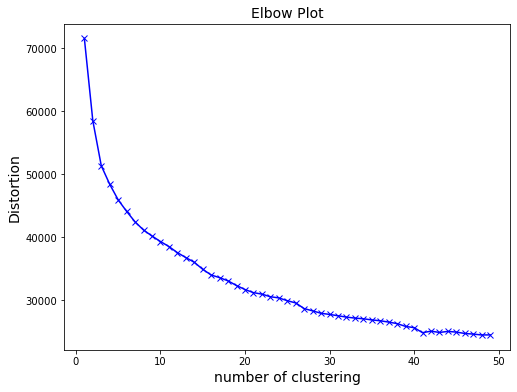

In [50]:
distortions = []
for i in range(1,50):
    X_scale = scaler.transform(X_train)
    km_mod = KMeans(n_clusters=i, init='random', max_iter=300, n_init=10, random_state=0)
    km_mod.fit(X_scale)
#   print(km_mod.inertia_)
    distortions.append(km_mod.inertia_)


plt.figure(figsize=(8,6))
plt.plot(range(1,50), distortions, 'bx-')
plt.xlabel('number of clusters', fontsize = 14)
plt.ylabel('Distortion', fontsize = 14)
plt.title('Elbow Plot', fontsize = 14)

Text(0.5, 1.0, 'Elbow Plot')

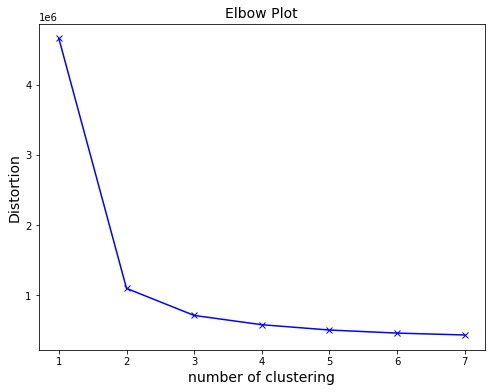

In [24]:
distortions = []
for i in range(1,8):
    km = KMeans (
        n_clusters=i, 
        init='random', 
        max_iter = 300, 
        n_init=10, 
        random_state = 0
    ).fit(X_train)
    distortions.append(km.inertia_)
    
plt.figure(figsize=(8,6))
plt.plot(range(1,8), distortions, 'bx-')
plt.xlabel('number of clustering', fontsize = 14)
plt.ylabel('Distortion', fontsize = 14)
plt.title('Elbow Plot', fontsize = 14)

In [65]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
km_mod = KMeans (
        n_clusters=10, 
        init='random', 
        max_iter = 300, 
        n_init=10, 
        random_state = 0
    ).fit(X_scaled)
#y_km = km.fit_predict(X_test)
y_km_train = km_mod.fit_predict(X_scaled)
y_km_test = km_mod.fit_predict(scaler.transform(X_test))

In [66]:
np.unique(y_km_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [67]:
len(y_km_train)+len(y_km_test)

5592

In [68]:
Y_train['cluster'] = y_km_train
Y_test['cluster'] = y_km_test
cluster_data = pd.concat([Y_train,Y_test])
cluster_data

<ipython-input-68-00fa9745b356>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train['cluster'] = y_km_train
<ipython-input-68-00fa9745b356>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_test['cluster'] = y_km_test


,PLAYER_ID,SEASON_ID,TEAM_ID_x,TEAM_ABBREVIATION,cluster
20919,203473,2018-19,1610612737,ATL,0
21958,1626174,2016-17,1610612766,CHA,8
20439,203078,2013-14,1610612764,WAS,4
8365,2561,2013-14,1610612754,IND,7
20243,202704,2012-13,1610612760,OKC,2
...,...,...,...,...,...
18808,201572,2013-14,1610612751,BKN,7
7853,2403,2004-05,1610612743,DEN,7
7421,2202,2010-11,1610612756,PHX,1
22340,1627832,2017-18,1610612761,TOR,3


In [69]:
player_cluster = pd.merge(player_data, cluster_data, on=["PLAYER_ID", "SEASON_ID","TEAM_ID_x","TEAM_ABBREVIATION"])

In [70]:
player_cluster['cluster'].value_counts()

8    1027
3     841
1     711
4     613
7     576
2     570
5     536
0     372
9     282
6     190
Name: cluster, dtype: int64

In [71]:
player_cluster[player_cluster['cluster']==0].describe()

,PLAYER_ID,TEAM_ID_x,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,...,TOV,PF,PTS_x,HEIGHT,WEIGHT,SEASON_EXP,PTS_y,AST_y,REB_y,cluster
count,3.720000e+02,3.720000e+02,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,...,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.0
mean,3.607021e+05,1.610613e+09,25.779570,52.602151,12.051075,949.827957,5.371774,11.639247,0.463468,0.695430,...,2.066398,4.218280,13.819624,81.209677,237.188172,7.516129,7.524731,1.177688,4.272581,0.0
std,5.514357e+05,8.649313e+00,4.029515,22.822243,14.673447,590.015873,1.340851,2.454858,0.073921,0.648661,...,1.740504,1.242244,3.119751,1.978077,18.571261,4.144591,4.423885,0.992349,2.095870,0.0
min,1.090000e+02,1.610613e+09,19.000000,1.000000,0.000000,3.000000,0.000000,4.300000,0.000000,0.000000,...,0.000000,0.000000,0.000000,73.000000,174.000000,1.000000,0.000000,0.100000,0.000000,0.0
25%,2.832000e+03,1.610613e+09,23.000000,36.000000,1.000000,447.000000,4.600000,9.900000,0.425000,0.100000,...,1.500000,3.500000,12.275000,80.000000,226.750000,4.000000,4.600000,0.600000,2.800000,0.0
50%,2.015900e+05,1.610613e+09,25.000000,59.000000,6.000000,933.500000,5.300000,11.500000,0.462500,0.500000,...,1.900000,4.100000,13.500000,81.000000,238.000000,7.000000,6.500000,0.900000,4.000000,0.0
75%,2.034760e+05,1.610613e+09,28.000000,72.000000,18.000000,1407.250000,6.100000,13.125000,0.504500,1.100000,...,2.300000,4.800000,15.400000,83.000000,250.000000,10.000000,9.200000,1.400000,5.400000,0.0
max,1.629203e+06,1.610613e+09,40.000000,82.000000,77.000000,2585.000000,13.100000,22.900000,0.700000,3.500000,...,28.200000,14.100000,29.500000,86.000000,289.000000,19.000000,29.000000,8.400000,13.500000,0.0


In [72]:
player_cluster[player_cluster['cluster']==1].describe()

,PLAYER_ID,TEAM_ID_x,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,...,TOV,PF,PTS_x,HEIGHT,WEIGHT,SEASON_EXP,PTS_y,AST_y,REB_y,cluster
count,7.110000e+02,7.110000e+02,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,...,711.000000,711.000000,711.00000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.0
mean,2.890584e+05,1.610613e+09,26.938115,53.987342,19.493671,1302.389592,5.792264,13.642897,0.426632,1.978762,...,1.853446,2.857525,16.03488,77.599156,211.476793,9.431786,10.395359,2.040225,3.147117,1.0
std,4.918774e+05,8.688218e+00,4.227888,24.485606,24.455989,777.550680,1.191335,2.400875,0.057104,0.966589,...,0.666998,0.954011,3.04119,2.988890,21.342062,4.644312,4.864742,1.338672,1.632630,0.0
min,1.500000e+01,1.610613e+09,19.000000,1.000000,0.000000,4.000000,0.000000,6.100000,0.000000,0.000000,...,0.000000,0.000000,7.20000,65.000000,133.000000,0.000000,0.000000,0.100000,0.000000,1.0
25%,2.561500e+03,1.610613e+09,24.000000,34.000000,1.000000,651.500000,5.100000,12.250000,0.402000,1.400000,...,1.400000,2.300000,14.30000,75.000000,198.000000,6.000000,7.000000,1.100000,2.000000,1.0
50%,2.011650e+05,1.610613e+09,26.000000,61.000000,9.000000,1351.000000,5.700000,13.500000,0.427000,1.900000,...,1.800000,2.800000,15.80000,78.000000,212.000000,10.000000,9.700000,1.700000,2.800000,1.0
75%,2.030950e+05,1.610613e+09,30.000000,76.000000,28.500000,1932.000000,6.400000,15.150000,0.454500,2.400000,...,2.200000,3.300000,17.60000,79.000000,225.000000,13.000000,13.200000,2.700000,4.100000,1.0
max,1.629168e+06,1.610613e+09,42.000000,82.000000,82.000000,3208.000000,12.800000,24.700000,1.000000,9.600000,...,4.900000,11.600000,38.60000,86.000000,281.000000,22.000000,31.800000,11.200000,11.700000,1.0


In [73]:
player_cluster[player_cluster['cluster']==2].describe()

,PLAYER_ID,TEAM_ID_x,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,...,TOV,PF,PTS_x,HEIGHT,WEIGHT,SEASON_EXP,PTS_y,AST_y,REB_y,cluster
count,5.700000e+02,5.700000e+02,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,...,570.000000,570.000000,570.000000,570.000000,570.00000,570.000000,570.000000,570.000000,570.000000,570.0
mean,2.783522e+05,1.610613e+09,26.963158,46.028070,11.864912,926.554386,4.228246,10.604211,0.392921,0.900702,...,2.547895,3.217544,11.414737,75.180702,196.94386,8.182456,7.625439,3.122105,2.413509,2.0
std,4.800097e+05,8.789572e+00,4.616435,25.358711,16.955260,693.989246,1.378937,2.729894,0.086930,0.620674,...,0.835780,1.205833,3.570317,2.866811,19.50180,4.634444,4.021852,1.670051,1.182225,0.0
min,2.430000e+02,1.610613e+09,19.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,65.000000,133.00000,0.000000,0.000000,0.000000,0.200000,2.0
25%,2.590000e+03,1.610613e+09,23.000000,24.000000,0.000000,272.000000,3.500000,9.200000,0.369000,0.400000,...,2.100000,2.500000,9.700000,73.250000,185.00000,4.000000,4.700000,1.900000,1.600000,2.0
50%,2.008260e+05,1.610613e+09,26.000000,48.000000,3.000000,841.500000,4.300000,10.600000,0.406000,0.900000,...,2.500000,3.000000,11.700000,75.000000,195.00000,8.000000,7.000000,3.000000,2.200000,2.0
75%,2.027210e+05,1.610613e+09,30.000000,69.000000,18.000000,1475.750000,5.100000,12.200000,0.438750,1.300000,...,3.000000,3.800000,13.700000,76.000000,205.00000,12.000000,9.375000,4.175000,2.900000,2.0
max,1.629067e+06,1.610613e+09,40.000000,82.000000,82.000000,2642.000000,8.200000,19.100000,0.667000,2.700000,...,5.800000,12.100000,20.000000,86.000000,280.00000,20.000000,29.000000,8.700000,7.100000,2.0


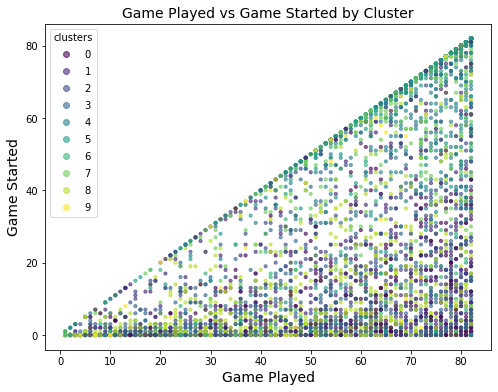

In [74]:
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(player_cluster.GP, player_cluster.GS, c=player_cluster.cluster, alpha = 0.6, s=10)
ax.set_title('Game Played vs Game Started by Cluster', fontsize = 14)
ax.set_ylabel('Game Started', fontsize = 14)
ax.set_xlabel('Game Played', fontsize = 14)
ax.legend(*sc.legend_elements(), title='clusters')

C:\Users\spenc\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


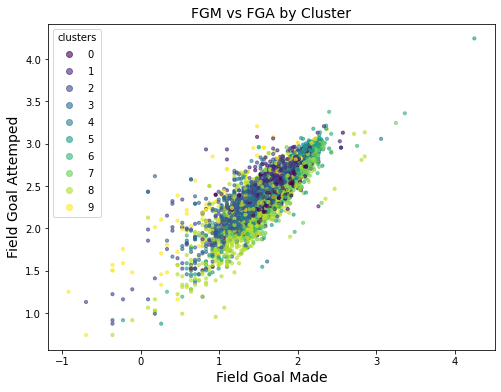

In [75]:
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(np.log(player_cluster.FGM), np.log(player_cluster.FGA), c=player_cluster.cluster, alpha = 0.6, s=10)
ax.set_title('FGM vs FGA by Cluster', fontsize = 14)
ax.set_ylabel('Field Goal Attemped', fontsize = 14)
ax.set_xlabel('Field Goal Made', fontsize = 14)
ax.legend(*sc.legend_elements(), title='clusters')

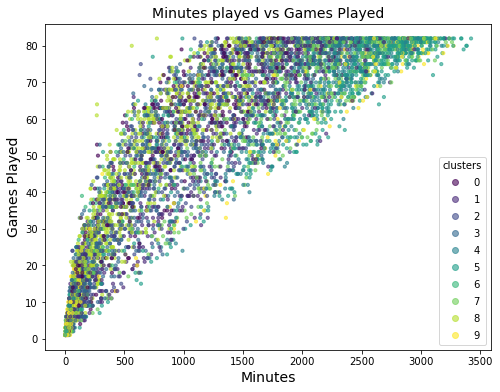

In [76]:
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(player_cluster.MIN, player_cluster.GP, c=player_cluster.cluster, alpha = 0.6, s=10)
ax.set_title('Minutes played vs Games Played', fontsize = 14)
ax.set_ylabel('Games Played', fontsize = 14)
ax.set_xlabel('Minutes', fontsize = 14)
ax.legend(*sc.legend_elements(), title='clusters')

In [79]:
player_cluster.PTS_x.describe()

count    5718.000000
mean       13.684103
std         5.578699
min         0.000000
25%        10.500000
50%        13.300000
75%        16.400000
max       209.000000
Name: PTS_x, dtype: float64

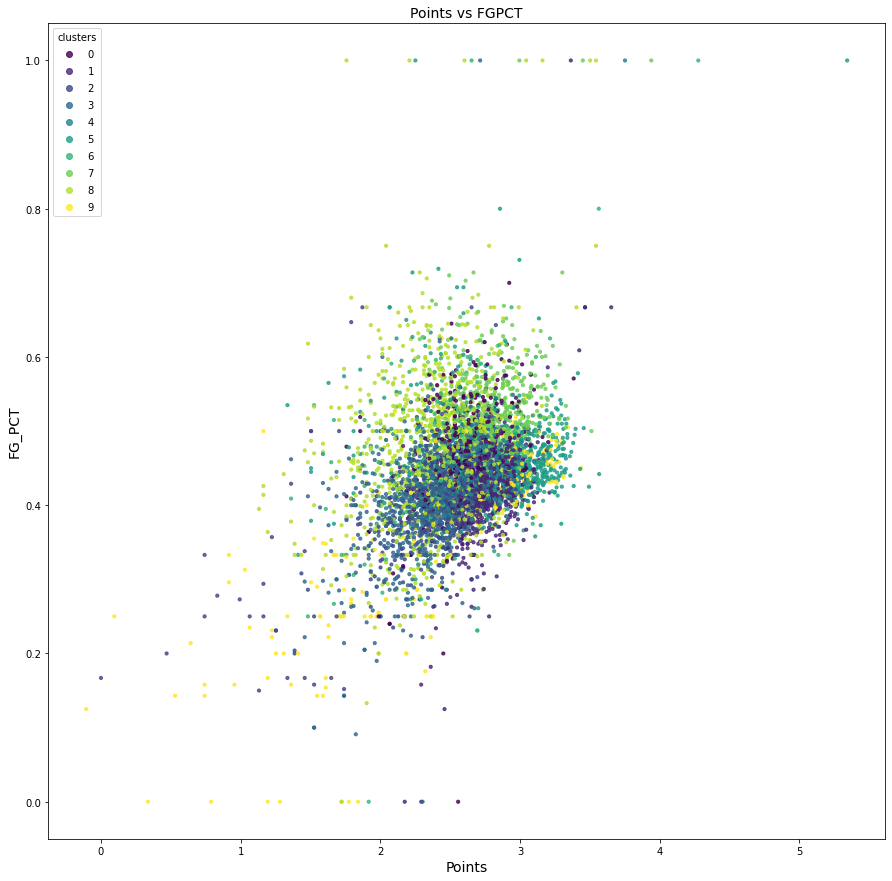

In [84]:
fig, ax = plt.subplots(figsize=(15,15))
sc = ax.scatter(np.log(player_cluster.PTS_x), player_cluster.FG_PCT, c=player_cluster.cluster, alpha = 0.8, s=10)
ax.set_title('Points vs FGPCT', fontsize = 14)
ax.set_ylabel('FG_PCT', fontsize = 14)
ax.set_xlabel('Points', fontsize = 14)
ax.legend(*sc.legend_elements(), title='clusters')

In [75]:
pca = PCA(n_components=3)
train_pca = pca.fit_transform(X_train)
test_pca = pca.transform(X_test)

gmm=GaussianMixture(n_components = 3, covariance_type='full', random_state=12345).fit(train_pca)


In [80]:
grouped_clusters = player_cluster.groupby('cluster')